In [1]:
import os
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np

import sys
sys.path.append('../src')

from tree import PairwiseDistanceMatrix

In [2]:
def align_depth(file):
    with open(file) as handle:
        return np.mean([int(line.split()[-1]) for line in handle])

In [3]:
base_dirpath = Path('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo')
labels = [
    'IlluminaWGS',
    'NanoporeWGS', 'NanoporeWGSFix1', 'NanoporeWGSFix2', 'NanoporeWGSFix3', 'NanoporeWGSFix4',
    'NanoporeWGS2',
    'NanoporeWGA', 'NanoporeWGA2', 'NanoporeWGA3', 'NanoporeWGA4', 'NanoporeWGA5', 'NanoporeWGA6',
]

sample_names = [
    'R19-2905',
    'R20-0026',
    'R20-0030',
    'R20-0088',
    'R20-0127',
    'R20-0131',
    'R20-0140',
    'R20-0145',
    'R20-0148',
    'R20-0150',
    'R20-0158',
    'R20-0160',
]

In [4]:
reference_dirpath = base_dirpath/'Unicycler'

In [5]:
data = []
for label in labels:
    for query in (base_dirpath/label/'Profile').iterdir():
        sample_name = query.stem
        subject = reference_dirpath/'Profile'/(sample_name + '.tsv')
        query_df = pd.read_csv(query, sep='\t', index_col=0)
        subject_df = pd.read_csv(subject, sep='\t', index_col=0)
        distance = sum(query_df['allele_id'].fillna(0) != subject_df['allele_id'].fillna(0))
        data.append((sample_name, label, distance))

distance_df = pd.DataFrame(data, columns=['Isolate', 'Method', 'cgMLST_distance'])

In [6]:
data = []
for label in labels:
    dirpath = base_dirpath/label/'Depth'
    if dirpath.exists():
        for query in (base_dirpath/label/'Depth').iterdir():
            sample_name = query.stem
            depth = align_depth(query)
            data.append((sample_name, label, depth))

depth_df = pd.DataFrame(data, columns=['Isolate', 'Method', 'Depth'])

In [7]:
score_df = pd.DataFrame()
for label in labels:
    for query in (base_dirpath/label/'assembly_accuracy').iterdir():
        sample_name = query.stem
        df = pd.read_csv(query, sep='\t', usecols=['qscore', 'segment_median_qscore', 'num_mismatches', 'num_insertions', 'num_deletions'])
        df.index = [sample_name]
        df['Method'] = label
        score_df = pd.concat([score_df, df])
score_df.index.name = 'Isolate'
score_df = score_df.reset_index()

In [8]:
summeries = distance_df.merge(depth_df, how='outer').merge(score_df, how='outer')

In [9]:
summeries['Depth'] = summeries['Depth'].round(2)

In [11]:
summeries

,Isolate,Method,cgMLST_distance,Depth,qscore,segment_median_qscore,num_mismatches,num_insertions,num_deletions
0,R20-0030,IlluminaWGS,0,65.90,57.65,90.0,0,4,1
1,R20-0140,IlluminaWGS,0,86.52,37.39,90.0,3,510,0
2,R20-0145,IlluminaWGS,0,83.34,31.09,90.0,4,0,2226
3,R20-0158,IlluminaWGS,0,100.02,33.37,90.0,1,0,1334
4,R20-0160,IlluminaWGS,0,105.92,35.89,90.0,2,0,758
...,...,...,...,...,...,...,...,...,...
87,R20-0148,NanoporeWGA6,8,205.43,25.64,90.0,23,7917,23
88,R20-0150,NanoporeWGA6,1,138.62,26.91,90.0,14,14,6023
89,R20-0127,NanoporeWGA6,8,209.01,47.11,90.0,6,17,35
90,R20-0145,NanoporeWGA6,5,140.53,47.88,90.0,20,10,17


In [12]:
pivot_table = pd.pivot_table(summeries, ['cgMLST_distance', 'Depth', 'qscore'], index=['Isolate'], columns=['Method'],)

In [13]:
pivot_table.columns = pivot_table.columns.swaplevel(0, 1)
pivot_table = pivot_table.sort_index(axis=1)
pivot_table

Method   IlluminaWGS                        NanoporeWGA                  \
               Depth cgMLST_distance qscore       Depth cgMLST_distance   
Isolate                                                                   
R19-2905       69.10             0.0  53.98       47.26           166.0   
R20-0026       55.51             0.0  56.72       72.08            76.0   
R20-0030       65.90             0.0  57.65       58.57           138.0   
R20-0088       59.55             0.0  44.45       25.02           312.0   
R20-0127       88.76             0.0  59.82      109.19            39.0   
R20-0131       62.38             0.0  64.54       42.21           196.0   
R20-0140       86.52             0.0  37.39       51.38           222.0   
R20-0145       83.34             0.0  31.09       36.86           270.0   
R20-0148      105.26             0.0  40.62      123.90            26.0   
R20-0150       88.25             0.0  40.77      136.58            24.0   
R20-0158      100.02             0.0  33.37       48.53           144.0   
R20-0160      105.92             0.0  35.89       39.54           249.0   

Method          NanoporeWGA2                        NanoporeWGA3  ...  \
         qscore        Depth cgMLST_distance qscore        Depth  ...   
Isolate                                                           ...   
R19-2905  27.20       112.24            33.0  37.59          NaN  ...   
R20-0026  33.09          NaN             NaN    NaN          NaN  ...   
R20-0030  19.52       120.21            53.0  42.50          NaN  ...   
R20-0088  28.96        78.70           156.0  25.75        30.17  ...   
R20-0127  39.11          NaN             NaN    NaN          NaN  ...   
R20-0131  36.10        48.32           487.0  33.37        37.47  ...   
R20-0140  26.70          NaN             NaN    NaN          NaN  ...   
R20-0145  25.10          NaN             NaN    NaN          NaN  ...   
R20-0148  49.73          NaN             NaN    NaN          NaN  ...   
R20-0150  40.56          NaN             NaN    NaN          NaN  ...   
R20-0158  24.06          NaN             NaN    NaN          NaN  ...   
R20-0160  35.95          NaN             NaN    NaN          NaN  ...   

Method      NanoporeWGS2        NanoporeWGSFix1        NanoporeWGSFix2         \
         cgMLST_distance qscore cgMLST_distance qscore cgMLST_distance qscore   
Isolate                                                                         
R19-2905             NaN    NaN             NaN    NaN             NaN    NaN   
R20-0026             NaN    NaN          1107.0  28.88           192.0  36.38   
R20-0030           548.0  33.76             NaN    NaN             NaN    NaN   
R20-0088             NaN    NaN             NaN    NaN             NaN    NaN   
R20-0127             NaN    NaN           745.0  32.23            14.0  43.15   
R20-0131             NaN    NaN             NaN    NaN             NaN    NaN   
R20-0140             4.0  32.19             NaN    NaN             NaN    NaN   
R20-0145             2.0  49.30             NaN    NaN             NaN    NaN   
R20-0148           741.0  32.18           860.0  31.08           432.0  34.66   
R20-0150             NaN    NaN           754.0  31.58            24.0  42.81   
R20-0158             NaN    NaN             NaN    NaN             NaN    NaN   
R20-0160             NaN    NaN             NaN    NaN             NaN    NaN   

Method   NanoporeWGSFix3        NanoporeWGSFix4         
         cgMLST_distance qscore cgMLST_distance qscore  
Isolate                                                 
R19-2905            25.0  39.50            25.0  39.50  
R20-0026             2.0  56.11             2.0  56.11  
R20-0030           424.0  33.46           424.0  33.46  
R20-0088            16.0  45.88             5.0  47.45  
R20-0127             1.0  46.00             1.0  46.00  
R20-0131            14.0  45.15             2.0  47.63  
R20-0140             9.0  31.87             3.0  

In [ ]:
sequence_type = pd.read_csv('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/Unicycler/MLST.tsv', sep='\t', usecols=['Key', 'ST'], index_col=0)
sequence_type = sequence_type['ST'].to_dict()

In [ ]:
pivot_table.insert(0, 'MLST' ,pivot_table.index.map(sequence_type))

In [ ]:
pivot_table

In [ ]:
with pd.ExcelWriter('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/report.xlsx') as writer:
    pivot_table.to_excel(writer)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
wgs = pd.concat([summeries.groupby('Method').get_group('NanoporeWGS'), summeries.groupby('Method').get_group('NanoporeWGS2')])
wgs = wgs.drop_duplicates('Isolate', keep='last')
wgs['Method'] = 'WGS'

In [16]:
wga = summeries.groupby('Method').get_group('NanoporeWGA6')
wga['Method'] = 'WGA'

/home/chen1i6c04/miniconda3/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
data = pd.concat([wga, wgs]).sort_values(['Isolate', 'Method'])

In [ ]:
data.to_csv('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/wga_and_wgs_comparison.tsv', sep='\t', index=False)

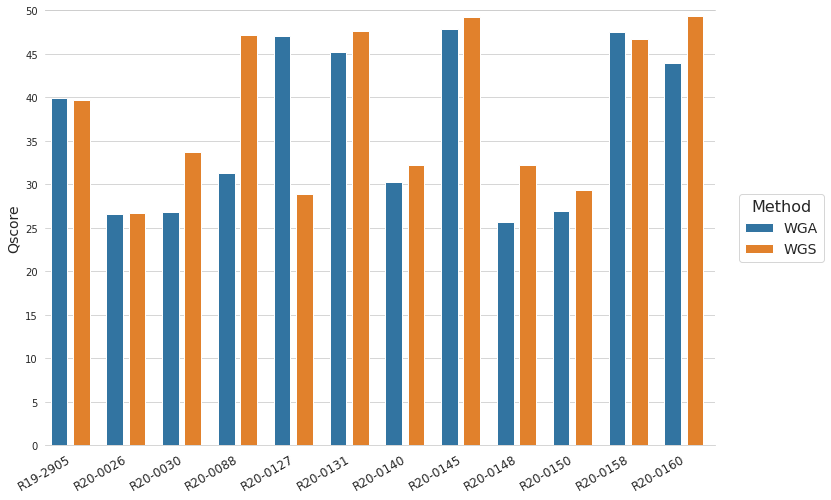

In [24]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.barplot(x='Isolate', y='qscore', hue='Method', data=data, ax=ax, dodge=True)
for bar in g.patches:
    bar.set_width(.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=12, ha='right');
ax.set_yticks(range(0, 51, 5))
ax.set_ylim(0, 50)
legend = ax.legend(bbox_to_anchor=(1.1, 0.5), title='Method', loc=10, fontsize=14)
plt.setp(legend.get_title(),fontsize=16)
ax.set_xlabel(None)
ax.set_ylabel('Qscore', fontsize=14)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
fig.savefig('/media/GenomicResearch/Issue/20201221_hybrid_and_denovo/Qscore.png', facecolor='w', bbox_inches='tight', dpi=150)